In [ ]:
# Clinical de-identification 

In [13]:
!pip install -q spacy pandas==2.2.1 numpy==1.26.4 regex transformers datasets accelerate torch
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
import os
import json
import regex as re
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict
import numpy as np

In [ ]:
DATA_PATH = "/kaggle/input/discharge-reports/Discharge Reports Dataset.csv"
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# ---------- Load data ----------
notes_df = pd.read_csv(DATA_PATH)
texts = notes_df["report"].astype(str).tolist()

In [17]:
# print(notes_df.head(8))

In [18]:
# Data smelling / EDA

print("Rows:", len(notes_df))
print("Columns:", notes_df.columns.tolist())

print("\nMissing values per column:")
print(notes_df.isna().sum())

if "note_type" in notes_df.columns:
    print("\nnote_type value counts:")
    print(notes_df["note_type"].value_counts().head(10))

# Parse time columns (if present)
for col in ["charttime", "storetime"]:
    if col in notes_df.columns:
        try:
            dt = pd.to_datetime(notes_df[col], errors="coerce")
            print(f"\n{col} min/max:", dt.min(), dt.max(), "missing:", int(dt.isna().sum()))
        except Exception as e:
            print(f"{col} parse error:", e)

# Text length stats
notes_df["report"] = notes_df["report"].astype(str)
notes_df["char_len"] = notes_df["report"].str.len()
notes_df["word_len"] = notes_df["report"].str.split().str.len()

print("\nReport length (chars) describe:")
print(notes_df["char_len"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))

print("\nReport length (words) describe:")
print(notes_df["word_len"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95]))

# Simple PII pattern prevalence
DATE_PATTERNS = [
    r"\b\d{4}-\d{2}-\d{2}\b",
    r"\b\d{2}/\d{2}/\d{4}\b",
    r"\b\d{2}-\d{2}-\d{4}\b",
    r"\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2},\s*\d{4}\b",
    r"\b\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{4}\b",
]
EMAIL_PATTERN = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
PHONE_PATTERN = r"\b(?:\+?\d{1,3}[\s.-]?)?(?:\(?\d{3}\)?[\s.-]?)?\d{3}[\s.-]?\d{4}\b"
ID_PATTERN = r"\b(?:MRN|ID|Unit No|Account)[#: ]*\s*\d+[\w-]*\b"

share_has = {
    "has_email": notes_df["report"].str.contains(EMAIL_PATTERN, regex=True, na=False).mean(),
    "has_phone": notes_df["report"].str.contains(PHONE_PATTERN, regex=True, na=False).mean(),
    "has_id_like": notes_df["report"].str.contains(ID_PATTERN, regex=True, na=False).mean(),
    "has_date_like": notes_df["report"].apply(lambda t: any(re.search(p, t, flags=re.IGNORECASE) for p in DATE_PATTERNS)).mean(),
}

print("\nShare of notes containing each PII type:")
for k, v in share_has.items():
    print(f"{k}: {v:.2%}")

# Per-note counts and save
def count_dates(text: str) -> int:
    return int(sum(len(re.findall(p, text, flags=re.IGNORECASE)) for p in DATE_PATTERNS))

counts_df = pd.DataFrame({
    "note_id": notes_df["note_id"],
    "char_len": notes_df["char_len"],
    "word_len": notes_df["word_len"],
    "num_dates": notes_df["report"].apply(count_dates),
    "num_emails": notes_df["report"].str.count(EMAIL_PATTERN, flags=re.IGNORECASE),
    "num_phones": notes_df["report"].str.count(PHONE_PATTERN),
    "num_ids": notes_df["report"].str.count(ID_PATTERN),
})

eda_counts_path = os.path.join(OUTPUT_DIR, "data_smell_counts.csv")
counts_df.to_csv(eda_counts_path, index=False)
print("\nSaved:", eda_counts_path)

# Quick previews of first few notes
pd.set_option("display.max_colwidth", 1000)
preview_df = notes_df.loc[:, ["note_id", "report"]].head(3).copy()
preview_df["report"] = preview_df["report"].apply(lambda t: (t[:600] + ("..." if len(t) > 600 else "")))
preview_df


Rows: 200
Columns: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'report']

Missing values per column:
note_id       0
subject_id    0
hadm_id       0
note_type     0
note_seq      0
charttime     0
storetime     0
report        0
dtype: int64

note_type value counts:
note_type
DS    200
Name: count, dtype: int64

charttime min/max: 2111-08-04 00:00:00 2202-11-09 00:00:00 missing: 0

storetime min/max: 2111-08-05 07:02:00 2202-11-10 19:28:00 missing: 0

Report length (chars) describe:
count      200.000000
mean     10984.470000
std       4359.657748
min       2437.000000
10%       6080.100000
25%       7562.750000
50%      10391.500000
75%      13505.500000
90%      17425.300000
95%      18836.850000
max      23662.000000
Name: char_len, dtype: float64

Report length (words) describe:
count     200.000000
mean     1670.945000
std       645.562325
min       346.000000
10%       951.800000
25%      1173.250000
50%      1598.500000
75%      2055.7

,note_id,report
0,10202247-DS-15,"Name: Alexandra Ruiz Unit No: 9295\n\nAdmission Date: 2025-01-02 Discharge Date: 2025-08-06\n\nDate of Birth: 2025-03-14 Sex: F\n\nService: MEDICINE\n\nAllergies:\nAnticholinergics,Other / Reglan\n\nAttending: Natasha Russell.\n\nChief Complaint:\nAbdominal pain\n\nMajor Surgical or Invasive Procedure:\nNone\n\nHistory of Present Illness:\nPatient is a 1984 yo woman with history of chronic pancreatitis\ns/p cholecystectomy and sphincterotomy who presents with 1wk of\nworsening abdominal pain. As per patient, the pain is\nintermittent, sharp and 0/10 (no pain) in quality. It localizes to her\nmid/righ upper abdomen an..."
1,12784119-DS-19,"Name: Lisa Alvarez Unit No: 9402\n\nAdmission Date: 2025-01-22 Discharge Date: 2025-01-05\n\nDate of Birth: 2025-05-10 Sex: M\n\nService: MEDICINE\n\nAllergies:\nShellfish\n\nAttending: Holly Burke.\n\nChief Complaint:\ncough, DOE\n\nMajor Surgical or Invasive Procedure:\nNone\n\nHistory of Present Illness:\n2001 y/o M with HIV (last known CD4~350), asthma, presents with\ncough and DOE x2 days. Patient reports sudden onset of cough 2\ndays ago, productive of thick, green sputum. Also complains of\npleuritic chest and RUQ pain with cough. Endorsing shortness of\nbreath with exertion, including speaking. Denies recent\n..."
2,16314105-DS-3,"Name: Christopher Howell Unit No: 9943\n\nAdmission Date: 2025-03-29 Discharge Date: 2025-04-05\n\nDate of Birth: 2025-02-17 Sex: F\n\nService: UROLOGY\n\nAllergies:\nPenicillins / pseudoephedrine / lisinopril\n\nAttending: Kristopher Vincent.\n\nChief Complaint:\nleft renal mass\n\nMajor Surgical or Invasive Procedure:\nRobotic left partial nephrectomy\n\nHistory of Present Illness:\nChristopher Howell is now 2023 years old, I have followed her for the last\nFollow diabetic diet instructions carefully and monitor blood sugar levels twice daily. years for a left kidney complex cystic mass. It is partially\ncystic p..."


In [22]:
from dataclasses import dataclass
from typing import List, Dict
import json, os
import regex as re

@dataclass
class MaskSpan:
    start: int
    end: int
    label: str

PLACEHOLDER_MAP = {
    "PERSON": "[NAME]",
    "PER": "[NAME]",
    "ORG": "[ORG]",
    "HOSPITAL": "[HOSPITAL]",
    "LOCATION": "[LOCATION]",
    "LOC": "[LOCATION]",
    "GPE": "[LOCATION]",
    "DATE": "[DATE]",
    "EMAIL": "[EMAIL]",
    "PHONE": "[PHONE]",
    "FAX": "[PHONE]",
    "ID": "[ID]",
}

# Precompiled regex
DATE_RE = [re.compile(p, re.IGNORECASE) for p in [
    r"\b\d{4}-\d{2}-\d{2}\b",
    r"\b\d{2}/\d{2}/\d{4}\b",
    r"\b\d{2}-\d{2}-\d{4}\b",
    r"\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2},\s*\d{4}\b",
    r"\b\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{4}\b",
]]
EMAIL_RE = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")
PHONE_RE = re.compile(r"\b(?:\+?\d{1,3}[\s.-]?)?(?:\(?\d{3}\)?[\s.-]?)?\d{3}[\s.-]?\d{4}\b")
ID_RE    = re.compile(r"\b(?:MRN|ID|Unit No|Account)[#: ]*\s*\d+[\w-]*\b")

def add_regex_spans(text: str, spans: List[MaskSpan]) -> None:
    for rgx in DATE_RE:
        spans.extend(MaskSpan(m.start(), m.end(), "DATE") for m in rgx.finditer(text))
    spans.extend(MaskSpan(m.start(), m.end(), "EMAIL") for m in EMAIL_RE.finditer(text))
    spans.extend(MaskSpan(m.start(), m.end(), "PHONE") for m in PHONE_RE.finditer(text))
    spans.extend(MaskSpan(m.start(), m.end(), "ID")    for m in ID_RE.finditer(text))

def apply_spans_mask(text: str, spans: List[MaskSpan]) -> str:
    spans_sorted = sorted(spans, key=lambda s: (s.start, -(s.end - s.start)))
    merged, prev_end = [], -1
    for s in spans_sorted:
        if s.start >= prev_end:
            merged.append(s)
            prev_end = s.end
    out, last = [], 0
    for s in merged:
        out.append(text[last:s.start])
        out.append(PLACEHOLDER_MAP.get(s.label, f"[{s.label}]"))
        last = s.end
    out.append(text[last:])
    return "".join(out)

def save_jsonl(path: str, texts_out: List[str]):
    with open(path, "w") as f:
        for t in texts_out:
            f.write(json.dumps({"text": t}, ensure_ascii=False) + "\n")
    print("Saved:", path)

In [ ]:
import spacy

# Use the larger model for better NER
nlp_spacy = spacy.load("en_core_web_lg")

# Header terms that should not be masked as entities
HEADER_PREFIXES = (
    "Name:", "Unit No:", "Admission Date:", "Discharge Date:", "Date of Birth:", "Sex:",
    "Service:", "Allergies:", "Attending:", "Chief Complaint:", "Major Surgical or Invasive Procedure:",
    "History of Present Illness:", "Past Medical History:", "Social History:", "Family History:",
    "Physical Exam:", "Pertinent Results:", "Medications on Admission:", "Discharge Medications:",
    "Discharge Instructions:", "Followup Instructions:", "Discharge Disposition:", "Discharge Diagnosis:",
)

# Quick filter to avoid masking tokens that are clearly section headers or common clinical tokens
def is_header_overlap(ent_text: str) -> bool:
    t = ent_text.strip()
    return any(t.startswith(p.split(":")[0]) for p in HEADER_PREFIXES)

def method1_spacy_regex(text: str) -> str:
    doc = nlp_spacy(text)
    spans: List[MaskSpan] = []
    for ent in doc.ents:
        # Prefer high-precision categories; avoid over-masking section words
        if ent.label_ in {"PERSON", "ORG", "GPE", "LOC", "FAC"} and not is_header_overlap(ent.text):
            label = "PERSON" if ent.label_ == "PERSON" else ("ORG" if ent.label_ == "ORG" else "LOCATION")
            spans.append(MaskSpan(ent.start_char, ent.end_char, label))
    add_regex_spans(text, spans)
    return apply_spans_mask(text, spans)

In [25]:
import spacy
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")
text = "John Doe visited AIIMS hospital in Delhi on 12 Jan 2024."
doc = nlp(text)

span1 = Span(doc, 0, 2, label="PERSON")
span2 = Span(doc, 3, 5, label="HOSPITAL")
span3 = Span(doc, 6, 7, label="LOCATION")

# Store in custom span group
doc.spans["my_spans"] = [span1, span2, span3]

for sp in doc.spans["my_spans"]:
    print(sp.text, sp.label_)


John Doe PERSON
AIIMS hospital HOSPITAL
Delhi LOCATION


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

MODEL_CANDIDATES = [
    "obi/deid_roberta_i2b2",          # PHI de-id if available
    "d4data/biomedical-ner-all",      # biomedical fallback
    "dslim/bert-base-NER",            # general fallback last
]

def load_med_pipeline():
    last_err = None
    for name in MODEL_CANDIDATES:
        try:
            tok = AutoTokenizer.from_pretrained(name)
            mdl = AutoModelForTokenClassification.from_pretrained(name)
            nlp = pipeline("token-classification", model=mdl, tokenizer=tok, aggregation_strategy="simple", device=-1)
            print("Loaded medical NER:", name)
            return nlp
        except Exception as e:
            print("Failed to load:", name, e)
            last_err = e
    raise RuntimeError(f"Could not load any model. Last error: {last_err}")

nlp_med = load_med_pipeline()

LABEL_MAP = {
    "PER": "PERSON", "PERSON": "PERSON", "PATIENT": "PERSON", "DOCTOR": "PERSON",
    "ORG": "ORG", "ORGANIZATION": "ORG", "HOSPITAL": "HOSPITAL",
    "LOC": "LOCATION", "LOCATION": "LOCATION", "GPE": "LOCATION",
    "CITY": "LOCATION", "STATE": "LOCATION", "STREET": "LOCATION", "ZIP": "LOCATION",
    "DATE": "DATE", "PHONE": "PHONE", "FAX": "PHONE", "EMAIL": "EMAIL", "ID": "ID",
}

HEADER_PREFIXES = (
    "Name:", "Unit No:", "Admission Date:", "Discharge Date:", "Date of Birth:", "Sex:",
    "Service:", "Allergies:", "Attending:", "Chief Complaint:", "Major Surgical or Invasive Procedure:",
)

def overlaps_header(text: str, start: int, end: int) -> bool:
    # if prediction text overlaps within the first 32 characters of a header line, ignore
    window = text[max(0, start-32):min(len(text), end+1)]
    return any(h in window for h in HEADER_PREFIXES)

def method2_medner_regex(text: str) -> str:
    preds = nlp_med(text)
    spans: List[MaskSpan] = []
    for p in preds:
        raw = str(p.get("entity_group", p.get("entity", ""))).upper().replace("B-", "").replace("I-", "")
        label = LABEL_MAP.get(raw, raw)
        if label in PLACEHOLDER_MAP:
            s, e = int(p["start"]), int(p["end"])
            if not overlaps_header(text, s, e):
                spans.append(MaskSpan(s, e, label))
    add_regex_spans(text, spans)
    return apply_spans_mask(text, spans)

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Loaded medical NER: dslim/bert-base-NER


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch, math, re

# Reuse regex for safety pass
SAFE_DATE = re.compile(r"\b\d{4}-\d{2}-\d{2}\b|\b\d{2}[/-]\d{2}[/-]\d{4}\b", re.I)
SAFE_EMAIL = EMAIL_RE
SAFE_PHONE = PHONE_RE
SAFE_ID    = ID_RE

SYSTEM_PROMPT = (
    "You are a de-identification assistant. Replace all personal identifiers (names, organizations, "
    "hospitals, locations, phone numbers, dates, emails, account/ID numbers) with placeholders "
    "[NAME], [ORG], [HOSPITAL], [LOCATION], [PHONE], [DATE], [EMAIL], [ID]. Keep clinical content. Return only the de-identified text.")

# Split long notes into overlapping chunks to avoid exceeding context window

def chunk_text(t: str, max_chars: int = 2000, overlap: int = 200) -> List[str]:
    if len(t) <= max_chars:
        return [t]
    chunks = []
    i = 0
    while i < len(t):
        chunks.append(t[i:i+max_chars])
        if i + max_chars >= len(t):
            break
        i = max(0, i + max_chars - overlap)
    return chunks

# Safety pass to enforce placeholders for residual structured PII

def safety_mask(text: str) -> str:
    text = SAFE_DATE.sub("[DATE]", text)
    text = SAFE_EMAIL.sub("[EMAIL]", text)
    text = SAFE_PHONE.sub("[PHONE]", text)
    text = SAFE_ID.sub("[ID]", text)
    return text


def method3_llm(texts_in: List[str], model_id: str = "microsoft/phi-3-mini-4k-instruct") -> List[str]:
    try:
        tok = AutoTokenizer.from_pretrained(model_id)
        model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float32, device_map="auto")
    except Exception as e:
        print("Primary LLM failed, falling back to TinyLlama:", e)
        model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
        tok = AutoTokenizer.from_pretrained(model_id)
        model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float32, device_map="auto")

    outs = []
    for t in texts_in:
        parts = chunk_text(t)
        masked_parts = []
        for part in parts:
            prompt = f"<|system|>\n{SYSTEM_PROMPT}\n<|user|>\n{part}\n<|assistant|>"
            inp = tok(prompt, return_tensors="pt", truncation=True)
            inp = {k: v.to(model.device) for k, v in inp.items()}
            gen = model.generate(**inp, max_new_tokens=384, do_sample=False)
            dec = tok.decode(gen[0], skip_special_tokens=True)
            seg = dec.split("<|assistant|>")[-1].strip()
            masked_parts.append(seg)
        merged = " ".join(masked_parts)
        merged = safety_mask(merged)
        outs.append(merged)
    return outs

In [28]:
# ---------- Run all ----------
m1 = [method1_spacy_regex(t) for t in texts]
save_jsonl(os.path.join(OUTPUT_DIR, "deid_method1_spacy_regex.jsonl"), m1)

m2 = [method2_medner_regex(t) for t in texts]
save_jsonl(os.path.join(OUTPUT_DIR, "deid_method2_medner_regex.jsonl"), m2)

try:
    m3 = method3_llm(texts)
    save_jsonl(os.path.join(OUTPUT_DIR, "deid_method3_llm.jsonl"), m3)
except Exception as e:
    print("LLM method failed:", e)
    m3 = [""] * len(texts)

Saved: /kaggle/working/deid_method1_spacy_regex.jsonl
Saved: /kaggle/working/deid_method2_medner_regex.jsonl


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4760 > 4096). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


Saved: /kaggle/working/deid_method3_llm.jsonl


In [29]:
# ---------- Quick comparison ----------
rows = []
for i, t in enumerate(texts):
    rows.append({
        "note_id": notes_df.iloc[i]["note_id"],
        "original": t,
        "method1": m1[i],
        "method2": m2[i],
        "method3": m3[i],
    })
cmp_path = os.path.join(OUTPUT_DIR, "deid_comparison_preview.csv")
pd.DataFrame(rows).to_csv(cmp_path, index=False)
print("Saved:", cmp_path)


Saved: /kaggle/working/deid_comparison_preview.csv


In [30]:
# ---------- Placeholder counts ----------
from collections import Counter
PHs = set(PLACEHOLDER_MAP.values())
def count_ph(x: str) -> Dict[str, int]:
    c = Counter()
    for ph in PHs:
        c[ph] = x.count(ph)
    return dict(c)

summary = []
for i in range(len(texts)):
    row = {"note_id": notes_df.iloc[i]["note_id"]}
    row.update({f"m1_{k}": v for k, v in count_ph(m1[i]).items()})
    row.update({f"m2_{k}": v for k, v in count_ph(m2[i]).items()})
    row.update({f"m3_{k}": v for k, v in count_ph(m3[i]).items()})
    summary.append(row)
sum_path = os.path.join(OUTPUT_DIR, "deid_placeholder_counts.csv")
pd.DataFrame(summary).to_csv(sum_path, index=False)
print("Saved:", sum_path)

Saved: /kaggle/working/deid_placeholder_counts.csv


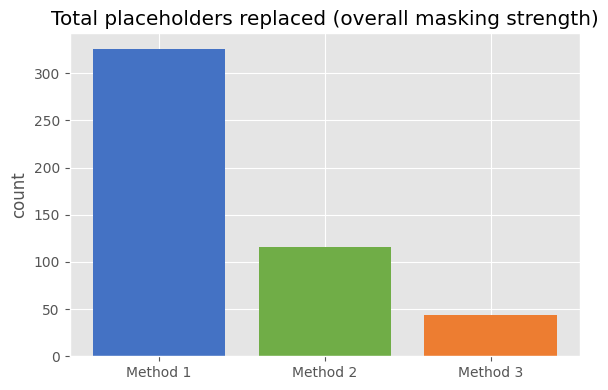

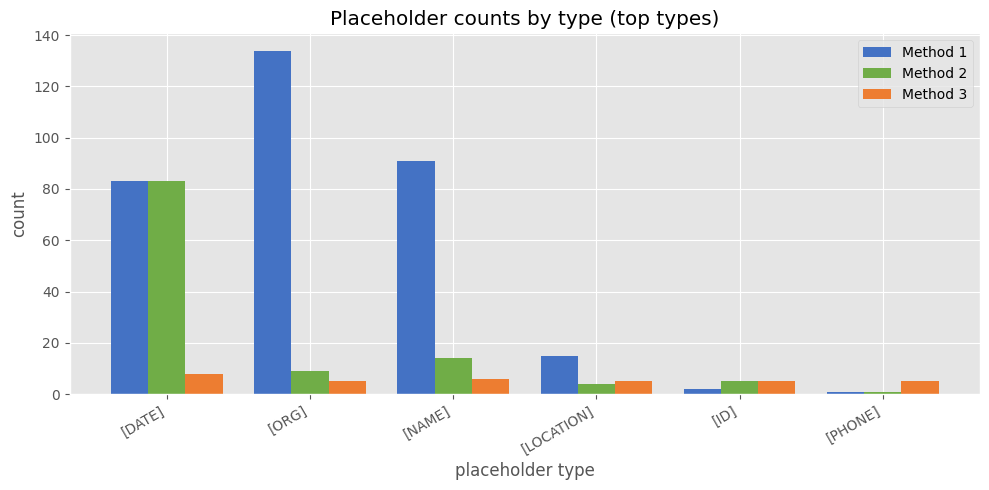

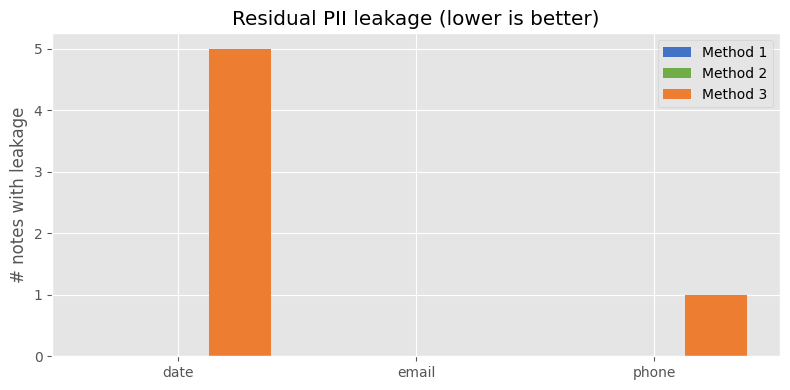

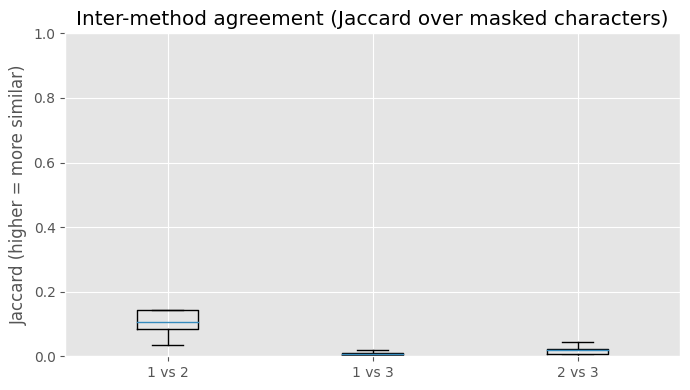

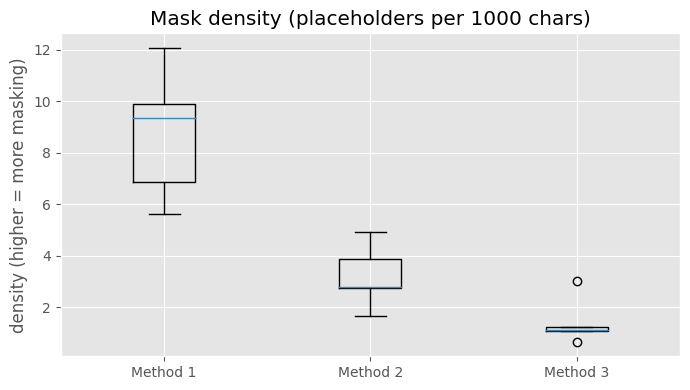

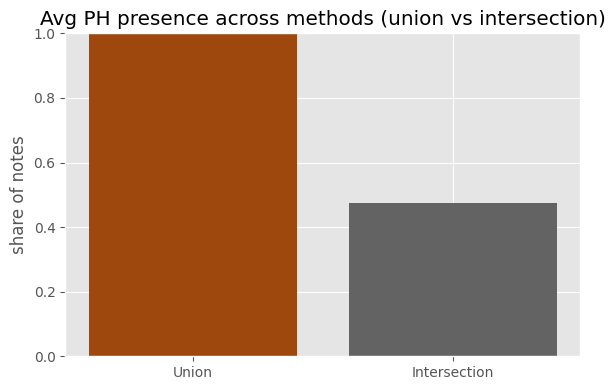

In [43]:
# De-identification scorecard: sequential, interpretable plots for Methods 1–3
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, regex as re
plt.style.use("ggplot")

# ---------- Ensure outputs and inputs ----------
OUTPUT_DIR = globals().get("OUTPUT_DIR", ".")
def load_jsonl(path: str):
    out = []
    if os.path.exists(path):
        with open(path) as f:
            for line in f:
                out.append(json.loads(line).get("text", ""))
    return out

if "m1" not in globals(): m1 = load_jsonl(os.path.join(OUTPUT_DIR, "deid_method1_spacy_regex.jsonl"))
if "m2" not in globals(): m2 = load_jsonl(os.path.join(OUTPUT_DIR, "deid_method2_medner_regex.jsonl"))
if "m3" not in globals(): m3 = load_jsonl(os.path.join(OUTPUT_DIR, "deid_method3_llm.jsonl"))

# Originals
if "notes_df" in globals() and "report" in notes_df.columns:
    originals = notes_df["report"].astype(str).tolist()
else:
    originals = m1 if len(m1) else []

N = min(len(m1), len(m2), len(m3), len(originals)) if originals else min(len(m1), len(m2), len(m3))
m1, m2, m3 = m1[:N], m2[:N], m3[:N]
orig = originals[:N] if originals else m1[:N]  # fallback

# Placeholders list
if "PLACEHOLDER_MAP" in globals():
    PH_LIST = sorted(set(PLACEHOLDER_MAP.values()))
else:
    PH_LIST = ["[NAME]","[ORG]","[HOSPITAL]","[LOCATION]","[PHONE]","[DATE]","[EMAIL]","[ID]"]

# ---------- Helpers ----------
def count_placeholders(text: str) -> dict:
    return {ph: text.count(ph) for ph in PH_LIST}

def masked_positions(text: str) -> set:
    pos = set()
    for ph in PH_LIST:
        s = 0
        while True:
            j = text.find(ph, s)
            if j == -1: break
            pos.update(range(j, j + len(ph)))
            s = j + len(ph)
    return pos

DATE_PATTERNS = [
    r"\b\d{4}-\d{2}-\d{2}\b", r"\b\d{2}/\d{2}/\d{4}\b", r"\b\d{2}-\d{2}-\d{4}\b",
    r"\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2},\s*\d{4}\b",
    r"\b\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{4}\b",
]
EMAIL_RE = re.compile(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b")
PHONE_RE = re.compile(r"\b(?:\+?\d{1,3}[\s.-]?)?(?:\(?\d{3}\)?[\s.-]?)?\d{3}[\s.-]?\d{4}\b")
def has_date(t: str) -> bool: return any(re.search(p, t) for p in DATE_PATTERNS)

# ---------- Build summary (placeholder counts per note per method) ----------
rows = []
for i in range(N):
    r = {}
    r.update({f"m1_{k}": v for k, v in count_placeholders(m1[i]).items()})
    r.update({f"m2_{k}": v for k, v in count_placeholders(m2[i]).items()})
    r.update({f"m3_{k}": v for k, v in count_placeholders(m3[i]).items()})
    rows.append(r)
summary_df = pd.DataFrame(rows).fillna(0)

ph_cols_m1 = [c for c in summary_df.columns if c.startswith("m1_")]
ph_cols_m2 = [c for c in summary_df.columns if c.startswith("m2_")]
ph_cols_m3 = [c for c in summary_df.columns if c.startswith("m3_")]

ph_types = [c.replace("m1_", "") for c in ph_cols_m1] if ph_cols_m1 else PH_LIST
m1_type = [summary_df.get(f"m1_{ph}", pd.Series([0])).sum() for ph in ph_types]
m2_type = [summary_df.get(f"m2_{ph}", pd.Series([0])).sum() for ph in ph_types]
m3_type = [summary_df.get(f"m3_{ph}", pd.Series([0])).sum() for ph in ph_types]

# Char lengths for density
char_lens = pd.Series([len(x) for x in orig]).replace(0, np.nan)

# ---------- Plot 1: Total placeholders per method ----------
total_m1 = summary_df[ph_cols_m1].sum().sum() if ph_cols_m1 else 0
total_m2 = summary_df[ph_cols_m2].sum().sum() if ph_cols_m2 else 0
total_m3 = summary_df[ph_cols_m3].sum().sum() if ph_cols_m3 else 0
plt.figure(figsize=(6, 4))
plt.bar(["Method 1","Method 2","Method 3"], [total_m1, total_m2, total_m3],
        color=["#4472C4","#70AD47","#ED7D31"])
plt.title("Total placeholders replaced (overall masking strength)")
plt.ylabel("count")
plt.tight_layout(); plt.show()

# ---------- Plot 2: Placeholder type breakdown (top 6 types) ----------
order = np.argsort(np.array(m1_type)+np.array(m2_type)+np.array(m3_type))[::-1][:min(6, len(ph_types))]
pt = [ph_types[i] for i in order]
x = np.arange(len(pt)); w = 0.26
plt.figure(figsize=(10, 5))
plt.bar(x - w, [m1_type[i] for i in order], width=w, label="Method 1", color="#4472C4")
plt.bar(x,       [m2_type[i] for i in order], width=w, label="Method 2", color="#70AD47")
plt.bar(x + w,   [m3_type[i] for i in order], width=w, label="Method 3", color="#ED7D31")
plt.xticks(x, pt, rotation=30, ha="right")
plt.title("Placeholder counts by type (top types)")
plt.xlabel("placeholder type"); plt.ylabel("count"); plt.legend()
plt.tight_layout(); plt.show()

# ---------- Plot 3: Residual PII leakage after masking ----------
def leakage_counts(texts):
    return dict(
        date=sum(1 for t in texts if has_date(t)),
        email=sum(1 for t in texts if EMAIL_RE.search(t)),
        phone=sum(1 for t in texts if PHONE_RE.search(t)),
    )
L1, L2, L3 = leakage_counts(m1), leakage_counts(m2), leakage_counts(m3)
types = ["date","email","phone"]; x = np.arange(len(types)); w = 0.26
plt.figure(figsize=(8, 4))
plt.bar(x - w, [L1[t] for t in types], width=w, label="Method 1", color="#4472C4")
plt.bar(x,       [L2[t] for t in types], width=w, label="Method 2", color="#70AD47")
plt.bar(x + w,   [L3[t] for t in types], width=w, label="Method 3", color="#ED7D31")
plt.xticks(x, types); plt.ylabel("# notes with leakage")
plt.title("Residual PII leakage (lower is better)"); plt.legend()
plt.tight_layout(); plt.show()

# ---------- Plot 4: Inter-method agreement (Jaccard of masked char positions) ----------
pairs = [("1 vs 2", m1, m2), ("1 vs 3", m1, m3), ("2 vs 3", m2, m3)]
data = {}
for label, A, B in pairs:
    scores = []
    for a, b in zip(A, B):
        pa, pb = masked_positions(a), masked_positions(b)
        if not pa and not pb: scores.append(1.0)
        else:
            u = len(pa | pb)
            scores.append(len(pa & pb)/u if u else 0.0)
    data[label] = scores
plt.figure(figsize=(7, 4))
plt.boxplot([data["1 vs 2"], data["1 vs 3"], data["2 vs 3"]],
            labels=["1 vs 2","1 vs 3","2 vs 3"])
plt.ylim(0, 1)
plt.title("Inter-method agreement (Jaccard over masked characters)")
plt.ylabel("Jaccard (higher = more similar)")
plt.tight_layout(); plt.show()

# ---------- Plot 5: Mask density (placeholders per 1000 chars) ----------
den_m1 = (summary_df[ph_cols_m1].sum(axis=1) / char_lens) * 1000 if ph_cols_m1 else pd.Series([0]*N)
den_m2 = (summary_df[ph_cols_m2].sum(axis=1) / char_lens) * 1000 if ph_cols_m2 else pd.Series([0]*N)
den_m3 = (summary_df[ph_cols_m3].sum(axis=1) / char_lens) * 1000 if ph_cols_m3 else pd.Series([0]*N)
plt.figure(figsize=(7, 4))
plt.boxplot([den_m1.fillna(0), den_m2.fillna(0), den_m3.fillna(0)],
            labels=["Method 1","Method 2","Method 3"])
plt.title("Mask density (placeholders per 1000 chars)")
plt.ylabel("density (higher = more masking)")
plt.tight_layout(); plt.show()

# ---------- Plot 6: Avg PH presence — union vs intersection across types ----------
def has_ph(text, ph): return ph in text
u_shares, i_shares = [], []
for ph in PH_LIST:
    u = sum(1 for i in range(N) if any(has_ph(x, ph) for x in (m1[i], m2[i], m3[i]))) / max(1, N)
    inter = sum(1 for i in range(N) if all(has_ph(x, ph) for x in (m1[i], m2[i], m3[i]))) / max(1, N)
    u_shares.append(u); i_shares.append(inter)
plt.figure(figsize=(6, 4))
plt.bar(["Union","Intersection"], [float(np.mean(u_shares)), float(np.mean(i_shares))],
        color=["#9E480E","#636363"])
plt.ylim(0, 1)
plt.title("Avg PH presence across methods (union vs intersection)")
plt.ylabel("share of notes")
plt.tight_layout(); plt.show()

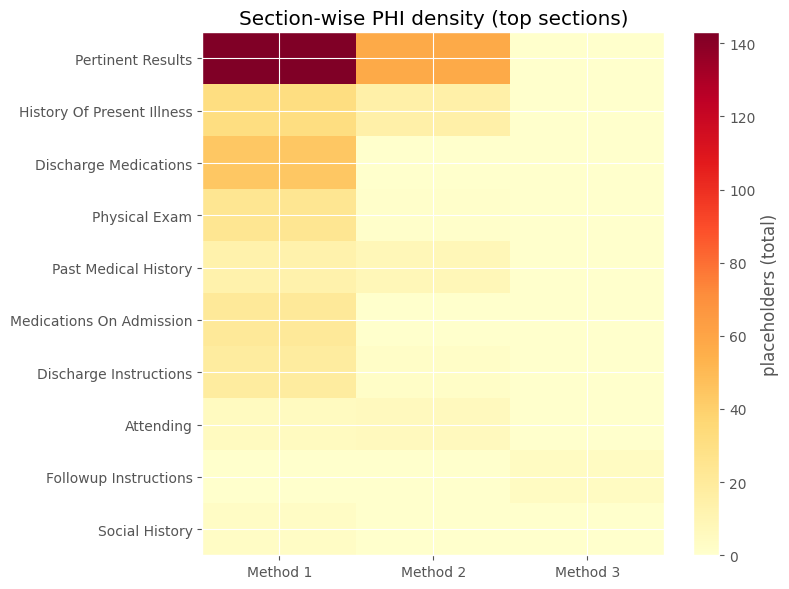

In [42]:
# Plot 4: Section-wise PHI density heatmap across methods
import regex as re
SEC_RE = re.compile(r"^(Allergies|Attending|Chief Complaint|History of Present Illness|Past Medical History|"
                    r"Social History|Family History|Physical Exam|Pertinent Results|Medications on Admission|"
                    r"Discharge Medications|Discharge Instructions|Followup Instructions):", re.I|re.M)

def section_counts(text):
    # returns dict: section -> total placeholders count in that section
    counts = {}
    parts = SEC_RE.split(text)
    # ['', 'Allergies', 'content', 'Attending', 'content', ...]
    for i in range(1, len(parts), 2):
        name = parts[i].strip().title()
        content = parts[i+1]
        c = sum(content.count(ph) for ph in PH_LIST)
        counts[name] = counts.get(name, 0) + c
    return counts

# aggregate across notes for each method
agg = {"Method 1": {}, "Method 2": {}, "Method 3": {}}
for txt in m1:
    for k,v in section_counts(txt).items(): agg["Method 1"][k] = agg["Method 1"].get(k,0) + v
for txt in m2:
    for k,v in section_counts(txt).items(): agg["Method 2"][k] = agg["Method 2"].get(k,0) + v
for txt in m3:
    for k,v in section_counts(txt).items(): agg["Method 3"][k] = agg["Method 3"].get(k,0) + v

df_sec = pd.DataFrame(agg).fillna(0)
# show top 10 sections by total placeholders (sum across methods)
top_sections = df_sec.sum(axis=1).sort_values(ascending=False).head(10).index
df_top = df_sec.loc[top_sections]

plt.figure(figsize=(8, 0.5*len(df_top)+1))
plt.imshow(df_top.values, aspect="auto", cmap="YlOrRd")
plt.colorbar(label="placeholders (total)")
plt.yticks(range(len(df_top.index)), df_top.index)
plt.xticks(range(len(df_top.columns)), df_top.columns, rotation=0)
plt.title("Section-wise PHI density (top sections)")
plt.tight_layout(); plt.show()